knihovna pro ga
https://deap.readthedocs.io/en/master/tutorials/basic/part2.html

**Instalace modulu**

In [ ]:
!python3 -m pip install numpy
!python3 -m pip install matplotlib

**Import modulu**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

**Nastaveni sesitu**

In [38]:
#uloz vygenerovane grafy do sesitu (bude videt na githubu)
%matplotlib inline                         

#uloz vygenerovane grafy do SVG formatu, vhodneho pro webove stranky
%config InlineBackend.figure_format = 'svg'

#pouzij seaborn graficky styl grafu (jsou hezci nez matplotlib)
plt.style.use("seaborn")

#nastavime pevne nahodne seminko pro opakovatelnost pri testovani kodu
np.random.seed(42)

**Vytvoreni modelu**

In [39]:
#nazvy mest
mesta = ['Chabarovice', 'Usti nad Labem', 'Praha', 'Brno', 'Karlovy Vary']

#vzdalenosti mezi mesty
matice_sousednosti = np.asarray(
    [
        [0, 10, 92, 296, 111],
        [10, 0, 91, 295, 119],
        [92, 91, 0, 205, 129],
        [296, 295, 205, 0, 336],
        [111, 119, 129, 336, 0],
    ]
)

**Vytvoreni tridy pro generaci**

In [45]:
class Generace():

    def __init__(self, jedinci, matice_sousednosti):
        self.jedinci = jedinci
        self.rodice = []
        self.nejlepsi_fitness = 0
        self.nejlepsi_jedinec = None
        self.matice_sousednosti = matice_sousednosti

**Funkce pro vytvoreni pocatecni populace**

In [46]:
def inicializace_populace(mesta, matice_sousednosti, velikost_populace):
    return Generace(
        #jedinci jsou reseny jako permutace poradi navstevy mest
        jedinci=np.asarray([np.random.permutation(mesta) for _ in range(velikost_populace)]), 
        matice_sousednosti=matice_sousednosti
    )

#vytvor pocatecni populaci
populace = inicializace_populace(mesta, matice_sousednosti, velikost_populace=10)

#vypis populaci na obrazovku
populace.jedinci

**Vypocet fitness jedince**

In [11]:
def fitness(self, chromosom):
    #fitness jedince je resena jako soucet vzdalenosti mezi mesty ve vygenerovanem poradi
    return sum([self.matice_sousednosti[chromosom[i],chromosom[i+1]] for i in range(len(chromosom) - 1)])

#pripoj funkci ke tride
Generace.fitness = fitness

**Ohodnoceni jedincu v populaci**

In [12]:
def ohodnoceni_populace(self):

    #spocitani fitness (celkova vzdalenost pri cestovani) pro vsechny jedince
    vzdalenosti = np.asarray([self.fitness(chromosome) for chromosome in self.jedinci])
    
    #nejlepsi fitness je jedinec s nejmensi celkovou vzdalenosti
    self.nejlepsi_fitness = np.min(vzdalenosti)

    #uloz si nejlepsiho jedince
    self.nejlepsi_jedinec = self.jedinci[vzdalenosti.tolist().index(self.nejlepsi_fitness)]

    #rodice budou nejlepsi jedinci z aktualni generace
    self.parents.append(self.best)

    #
    if False in (vzdalenosti[0] == vzdalenosti):
        vzdalenosti = np.max(vzdalenosti) - vzdalenosti

    #vrat normovanou fitness funkci jedince (vysec na kole rulety)
    return vzdalenosti / np.sum(vzdalenosti)

#pripoj funkci ke tride
Generace.ohodnoceni_populace = ohodnoceni_populace

#ohodnot populaci a vypis nejlepsiho jedince a jeho fitness
populace.ohodnoceni_populace()
print(populace.nejlepsi_jedinec)
print(populace.nejlepsi_fitness)

**Selekce**

In [16]:
def selekce(self, pocet_rodicu=4):

    #ziskej normovanou fitness jedincu v populaci
    fitnes = self.ohodnoceni_populace()

    #opakuj vybirani rodice rulout do te doby, dokud neni potrebny pocet rodicu
    while len(self.parents) < pocet_rodicu:

        #vyber nahodneho jedince z populace
        idx = np.random.randint(0, len(fitness))

        #cim vetsi fitness, tim vetsi sance na vyber jedince do rodicu
        if np.random.rand() < fitnes[idx]:
            self.parents.append(self.mesta[idx])

    #preved seznam rodicu na numpy array
    self.parents = np.asarray(self.parents)

#pripoj funkci ke tridy
Generace.select = selekce

#spust selekci a vypis nalezene rodice
populace.select()
print(populace.parents)

In [18]:
def swap(chromosome):
    a, b = np.random.choice(len(chromosome), 2)
    chromosome[a], chromosome[b] = (
        chromosome[b],
        chromosome[a],
    )
    return chromosome

In [19]:
def crossover(self, p_cross=0.1):
    children = []
    count, size = self.parents.shape
    for _ in range(len(self.mesta)):
        if np.random.rand() > p_cross:
            children.append(
                list(self.parents[np.random.randint(count, size=1)[0]])
            )
        else:
            parent1, parent2 = self.parents[
                np.random.randint(count, size=2), :
            ]
            idx = np.random.choice(range(size), size=2, replace=False)
            start, end = min(idx), max(idx)
            child = [None] * size
            for i in range(start, end + 1, 1):
                child[i] = parent1[i]
            pointer = 0
            for i in range(size):
                if child[i] is None:
                    while parent2[pointer] in child:
                        pointer += 1
                    child[i] = parent2[pointer]
            children.append(child)
    return children

Generace.crossover = crossover

In [20]:
def krizeni(self, p_krizeni=0.1, p_mutace=0.1):
    nova_generace = []
    potomci = self.krizeni(p_krizeni)
    for potomek in potomci:
        if np.random.rand() < p_mutace:
            nova_generace.append(swap(potomek))
        else:
            nova_generace.append(potomek)
    return nova_generace
    
Populace.krizeni = krizeni

In [21]:
populace.krizeni()

[[2, 0, 4, 1, 3],
 [2, 0, 4, 1, 3],
 [2, 0, 4, 1, 3],
 [1, 0, 4, 2, 3],
 [2, 0, 4, 1, 3]]

**Geneticky algoritmus**

In [22]:
def geneticky_algoritmus(
    mesta,                      #nazvy mest, mezi kterymi hledame optimalni trasu
    matice_sousednosti,         #metrika mest (napr. vzdalenost, cena), kterou optimalizujeme
    velikost_populace=5,        #pocet jedincu v kazde generaci
    pocet_iteraci=20,           #pocet iteraci vyvoje genetickeho algoritmus (nejvyssi generace)
    selektivita=0.15,           #mira selektivity pro selektivni operator
    p_krizeni=0.5,              #pravdepodobnost krizeni pro krizici operator
    p_mutace=0.1,               #pravdepodobnost mutace pro mutacni operator
    interval_tisknuti=100,      #po kolika generacich tisknout na obrazovku fitness skore
    vrat_historii=False,        #pokud je priznak pravdivy, pak funkce vrati vyvoj fitness v case
    verbosita=False             #pokud je priznak pravdivy, pak funkce vypisuje historii na obrazovku
    ):
    
    #vytvor pocatecni populaci z nazvu mest a jejich vzdalenosti
    populace = inicializace_populace(mesta, matice_sousednosti, velikost_populace)

    #pocatecni nejlepsi jedinec
    nejlepsi_jedinec = populace.nejlepsi_jedinec

    #pocateci nejlepsi fitness
    nejlepsi_fitness = float("inf")
    
    #historie skore pro vykresleni grafu
    historie = []

    #cyklus genetickeho algoritmu
    for i in range(pocet_iteraci):

        #selekce jedincu na rodice pristi generace
        populace.selekce(velikost_populace * selektivita)

        #pridej nejlepsi fitness do historie vyvoje fitness
        historie.append(populace.nejlepsi_fitness)

        #pokud je zapnuta verbosita (tiskne se fitness kazde generace)
        if verbosita:
            #tak vypisuj na obrazovku fitness kazde generace
            print(f"Generace {i}: {populace.nejlepsi_fitness}")
        #pokud neni zapnuta verbosita, tak tiskni po zadanem poctu iteraci
        elif i % interval_tisknuti == 0:
            print(f"Generace {i}: {populace.nejlepsi_fitness}")
        
        #pokud je nejlepsi fitness populace lepsi jak doposud nejlepsi nalezena fitness
        if populace.nejlepsi_fitness < nejlepsi_fitness:
            #uprav nejlepsi nalezenou fitness na fitness z aktualni populace
            nejlepsi_fitness = populace.nejlepsi_fitness
            #uloz si nejlepsi jedince
            nejlepsi_jedinec = populace.nejlepsi_jedinec

        #vytvor potomky krizenim a mutaci
        potomci = populace.krizeni(p_krizeni, p_mutace)

        #nahrad aktualni populaci novou generaci
        populace = Generace(potomci, populace.matice_sousednosti)

    #pokud je zapnut priznak pro navrat historie
    if vrat_historii:
        #tak vrat nejlepsiho nalezeneho jedince a historii
        return nejlepsi_jedinec, historie
    else:
        #jinak vrat jen nejlepsiho nalezeneho jedince
        return nejlepsi_jedinec

**Spust geneticky algoritmus**

In [23]:
geneticky_algoritmus(mesta, matice_sousednosti, verbosita=True)

Generation 0: 121.8
Generation 1: 121.8
Generation 2: 121.8
Generation 3: 121.8
Generation 4: 121.8
Generation 5: 114.28
Generation 6: 114.28
Generation 7: 114.28
Generation 8: 114.28
Generation 9: 114.28
Generation 10: 106.77
Generation 11: 106.77
Generation 12: 106.77
Generation 13: 106.77
Generation 14: 106.77
Generation 15: 106.77
Generation 16: 106.77
Generation 17: 106.77
Generation 18: 106.77
Generation 19: 106.77


[4, 0, 2, 3, 1]

Generation 0: 114.28
Generation 20: 106.77
Generation 40: 106.77
Generation 60: 104.13
Generation 80: 95.68


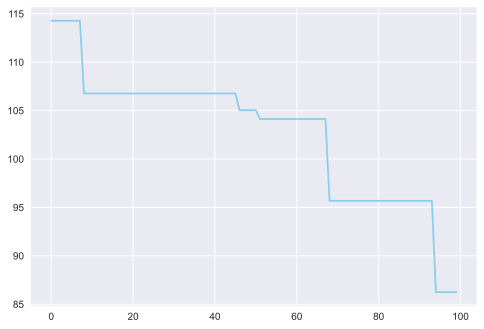

[4, 1, 3, 2, 0]


In [24]:
best, history = genetic_algorithm(
    mesta,
    matice_sousednosti,
    n_iter=100,
    verbose=False,
    print_interval=20,
    return_history=True,
)

plt.plot(range(len(history)), history, color="skyblue")
plt.show()
print(best)

In [25]:
def vytvor_mesta(n_mest, factor=10):
    return np.random.rand(n_mest, 2) * n_mest * factor

In [26]:
def make_mat(coordinates):
    res = [
        [get_distance(city1, city2) for city2 in coordinates]
        for city1 in coordinates
    ]
    return np.asarray(res)

def get_distance(city1, city2):
    return np.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)

In [27]:
test_coords = [[0, 0], [0, 1], [1, 1], [1, 0]]

make_mat(test_coords)

array([[0.        , 1.        , 1.41421356, 1.        ],
       [1.        , 0.        , 1.        , 1.41421356],
       [1.41421356, 1.        , 0.        , 1.        ],
       [1.        , 1.41421356, 1.        , 0.        ]])

In [28]:
vytvor_mesta(5)

array([[30.76490125,  4.17320425],
       [44.12081842, 40.18017677],
       [25.26033868, 48.35633076],
       [20.88804896, 49.20551595],
       [33.39599994, 31.73356366]])

Generation 0: 50011.65935498702
Generation 100: 30970.433045633214
Generation 200: 27486.721956799065
Generation 300: 25321.523175723258
Generation 400: 24245.68050461644
Generation 500: 22186.22085812617
Generation 600: 20514.62574300889
Generation 700: 20155.685751528705
Generation 800: 19359.224005414842
Generation 900: 18835.127308809744


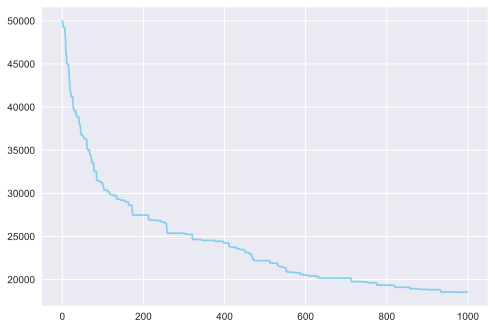

[75, 7, 73, 67, 93, 63, 74, 54, 96, 36, 3, 11, 5, 17, 87, 66, 98, 28, 56, 86, 30, 25, 20, 81, 2, 37, 76, 85, 78, 61, 48, 26, 49, 40, 39, 24, 69, 53, 99, 19, 60, 31, 50, 70, 23, 4, 42, 90, 33, 47, 71, 77, 91, 10, 34, 95, 51, 46, 38, 52, 79, 80, 15, 8, 21, 12, 0, 45, 88, 44, 29, 43, 58, 6, 41, 32, 92, 13, 83, 59, 1, 14, 82, 72, 68, 57, 22, 94, 65, 64, 9, 18, 35, 62, 97, 16, 89, 27, 55, 84]


In [29]:
mesta = range(100)
city_coordinates = vytvor_mesta(len(mesta))
matice_sousednosti = make_mat(city_coordinates)
best, history = genetic_algorithm(
    mesta, matice_sousednosti, n_population=20, n_iter=1000, verbose=False, return_history=True
)
plt.plot(range(len(history)), history, color="skyblue")
plt.show()
print(best)

In [30]:
def print_path(best, city_coordinates):
    points = city_coordinates[best]
    x, y = zip(*points)
    plt.plot(x, y, color="skyblue", marker="o")

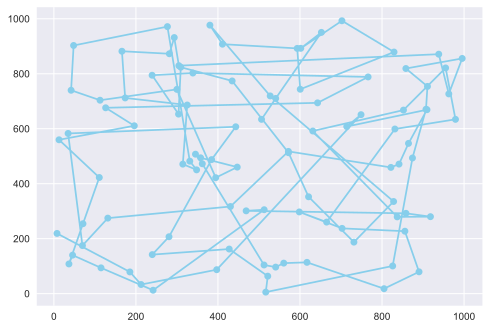

In [31]:
print_path(best, city_coordinates)

In [32]:
def mesta_za_sebou(n_mest, factor=0.2):
    x = np.asarray(range(int(-n_mest / 2), int(n_mest / 2) + 1, 1))
    y = np.sqrt(n_mest ** 2 / 4 - x ** 2)
    return np.asarray(list(zip(x, y)))

Generation 0: 2964.489767366144
Generation 500: 945.4172736946911
Generation 1000: 578.9946789148103
Generation 1500: 454.78082911700386
Generation 2000: 345.30974966985843
Generation 2500: 332.30083957826196
Generation 3000: 315.26048781375886
Generation 3500: 312.53650083474145
Generation 4000: 311.14608772798493
Generation 4500: 311.13946772717316
Generation 5000: 310.1251699016666
Generation 5500: 310.1251699016666


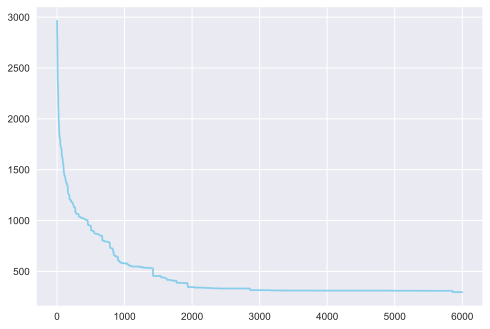

[83, 82, 81, 80, 79, 78, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 60, 59, 58, 57, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 61, 62, 63, 64, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 77, 76]


In [33]:
mesta = range(100)
city_coordinates = mesta_za_sebou(len(mesta))
matice_sousednosti = make_mat(city_coordinates)
best, history = genetic_algorithm(
    mesta, matice_sousednosti, n_population=500, selectivity=0.05,
    p_mut=0.05, p_cross=0.7, n_iter=6000, print_interval=500, verbose=False, return_history=True
)
plt.plot(range(len(history)), history, color="skyblue")
plt.show()
print(best)

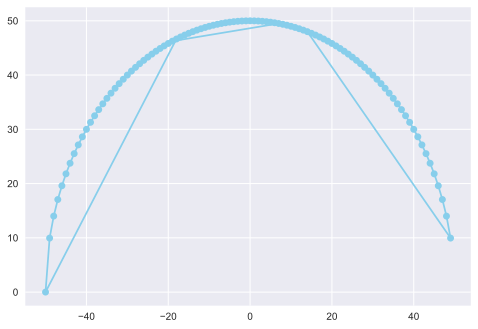

In [34]:
print_path(best, city_coordinates)

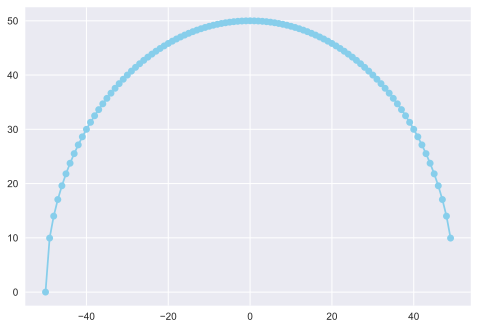

In [35]:
print_path(sorted(best), city_coordinates)